# Visualising the optical and X-ray positions on XMM images

We show the original optical position and X-ray position determined in this work on XMM images.

## Import statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch, MinMaxInterval
from astropy.convolution import convolve, Gaussian2DKernel
import os
from shutil import rmtree
from legacystamps import download as ls_download
import matplotlib
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 10
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/visualisation/')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import BaseSample
from xga.sas import emosaic
from xga.products import Image
from xga.imagetools.misc import pix_deg_scale
from xga.sourcetools.misc import ang_to_rad

%matplotlib inline

## Reading the sample file

This sample file is required again so that we know the central coordinates and redshifts of the groups.

In [2]:
samp = pd.read_csv('../../sample_files/init_group_info.csv')
samp = samp[samp['name'] != 'PHL1811']
samp

name      est_ra    est_dec  redshift
0   25124  243.629055  26.730240     0.186
1   44739  229.793620  28.331750     0.118
2  19670A  150.256710  50.793942     0.134
3  19670B  150.214920  50.805014     0.134
4   12833  129.496800  44.248700     0.145
5   44858  230.112000  28.887750     0.127
7   50433  157.758000  30.862000     0.136

## Reading sample of optical positions

In [3]:
opt_samp = pd.read_csv('../../sample_files/opt_group_info.csv')
opt_samp

name   opt_ra  opt_ra_err  opt_dec  opt_dec_err  redshift
0    25124  243.538       0.015   26.687        0.006     0.186
1    44739  229.822       0.019   28.342        0.058     0.118
2   19670A  150.178       0.028   50.784        0.007     0.134
3   19670B  150.178       0.028   50.784        0.007     0.134
4    12833  129.400       0.013   44.282        0.010     0.145
5    44858  230.084       0.035   28.873        0.008     0.127
6  PHL1811      NaN         NaN      NaN          NaN     0.077
7    50433  157.732       0.003   30.845        0.006     0.136

## Reading sample of member galaxies

In [4]:
mem_gal_samp = pd.read_csv("../../sample_files/member_galaxies.csv", dtype={'group_id': str})
mem_gal_samp = mem_gal_samp[mem_gal_samp['group_id'].isin(list(opt_samp['name'])+['19670'])]
mem_gal_samp

group_id             gal_name      ra_gal    dec_gal    z_gal  L_gal   
0      12833       rbs711_126_554  129.398389  44.325363  0.14572  0.575  \
1      12833       rbs711_135_607  129.383140  44.296795  0.14519  0.998   
2      12833  1237654652565651620  129.394131  44.314455  0.14505  1.660   
3      12833       rbs711_123_564  129.410462  44.330803  0.14518  1.050   
4      12833       rbs711_143_470  129.334488  44.319729  0.14485  1.440   
..       ...                  ...         ...        ...      ...    ...   
624    50433     fbqs1030_168_703  157.789722  30.856916  0.13856  0.823   
625    50433     fbqs1030_176_808  157.763286  30.824806  0.13372  1.000   
626    50433     fbqs1030_179_728  157.750955  30.846392  0.13887  0.312   
627    50433     fbqs1030_148_992  157.901502  30.807314  0.13497  1.300   
628    50433    fbqs1030_208_1186  157.587161  30.748926  0.13555  0.339   

    spec_type  delt_rho  delt_vel  p_mem  
0           A       323    -316.0   99.6  
1           A       265    -455.0   99.5  
2           A       261    -492.0   99.5  
3           C       340    -457.0   99.5  
4           A       631    -544.0   99.4  
..        ...       ...       ...    ...  
624         A       362     678.0   90.3  
625         C       378    -599.0   79.6  
626         A       169     760.0   79.0  
627         C      1293    -269.0   75.5  
628         C      1536    -116.0   66.9  

[310 rows x 10 columns]

In [5]:
mem_gal_samp['group_id'].value_counts()

group_id
44858    99
44739    59
12833    50
19670    48
25124    29
50433    25
Name: count, dtype: int64

## Declaring an XGA sample

A BaseSample object is declared, rather than an ExtendedSample or a ClusterSample, because initially we do not want any automated region matching to take place. From past work we know that some of these groups are very low surface brightness, and in some the major visible contribution to X-ray emission is from member galaxies.

This sample will not match to region files, but we can still use it to create images on which regions can be overlaid:

In [6]:
srcs = BaseSample(samp['est_ra'].values, samp['est_dec'].values, samp['redshift'].values, samp['name'].values)

Declaring BaseSource Sample: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


## Generate combined ratemaps

If a 'proper' ClusterSample had been declared, this process would have been run automatically, but in this case we manually generate combined 0.5-2.0 keV ratemaps by calling emosaic (with the default `lo_en=Quantity(0.5, 'keV')` and `hi_en=Quantity(2.0, 'keV')` values) separately for images and exposure maps. The count-rate maps are created automatically when a matching pair of image and exposure map are detected: 

In [7]:
emosaic(srcs, 'image')
emosaic(srcs, 'expmap')

## View XMM visualisations of the groups

A ratemap visualisation is created for each group (bar PHL1811), with the original optical position shown as the solid crosshair, and an uncertainty region shown as a dashed circle. The X-ray position determined in this work is shown by the dashed cross-hair. The XCS detection regions are overlaid on both:

25124


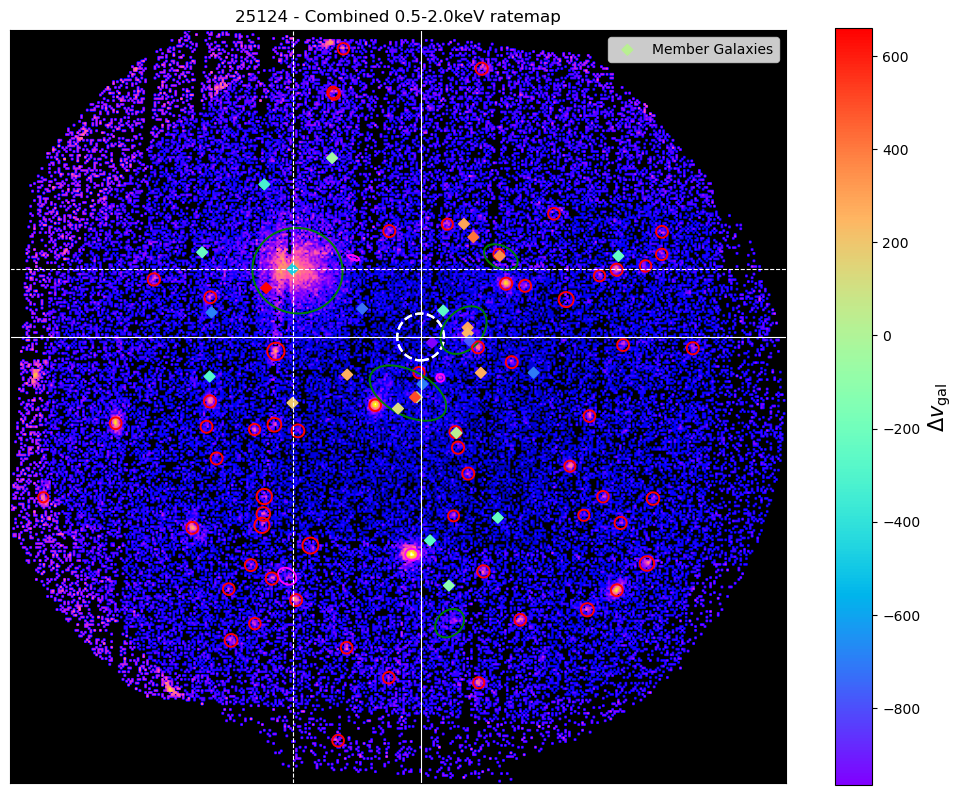

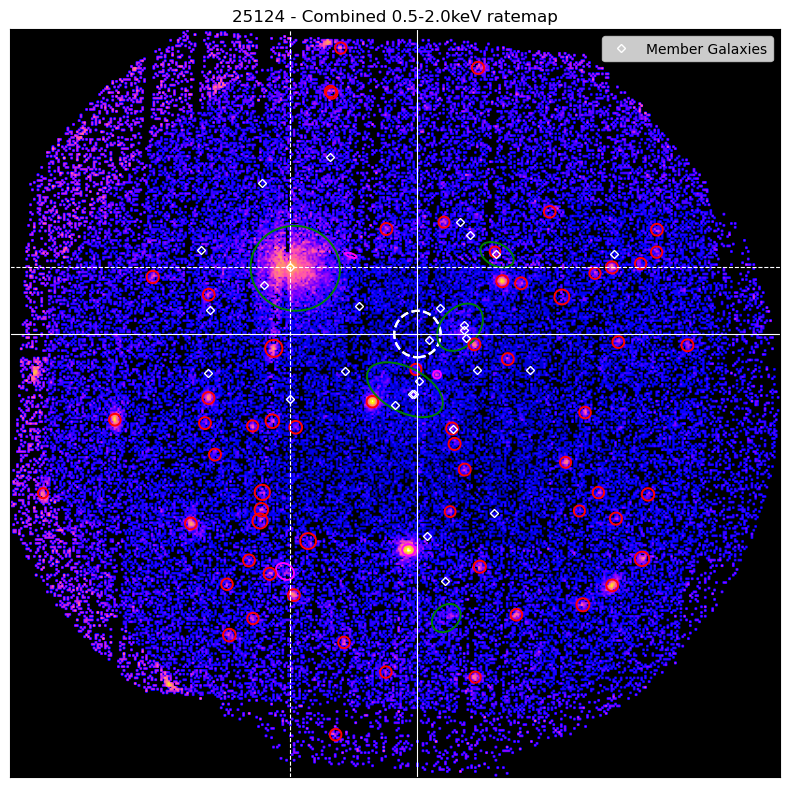




44739


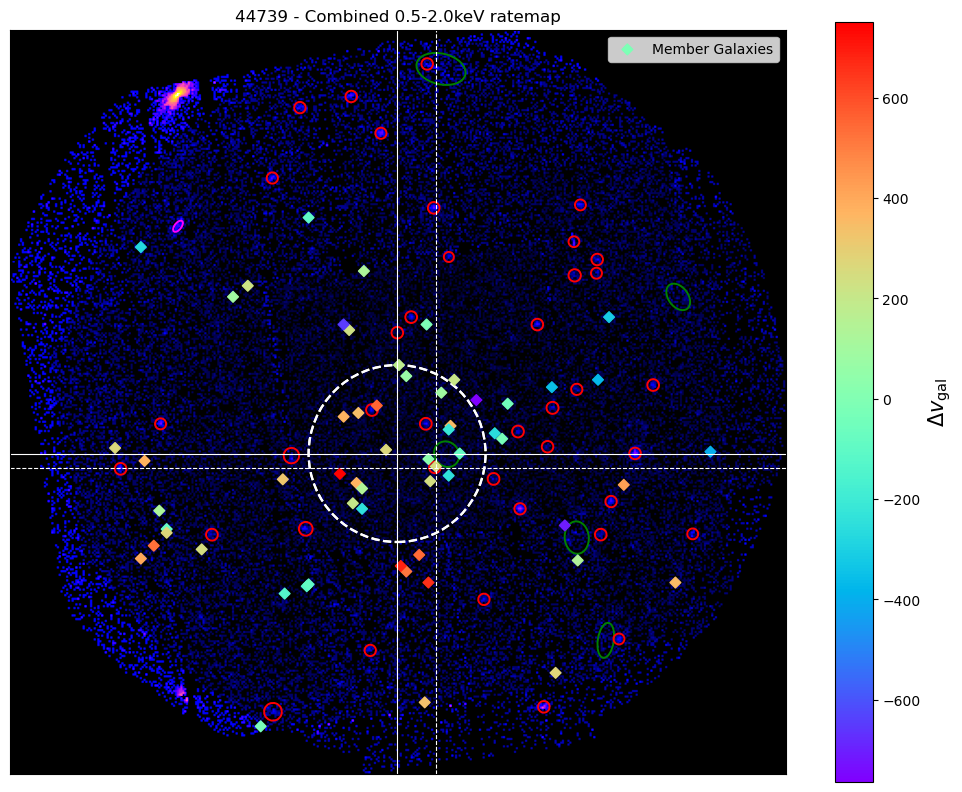

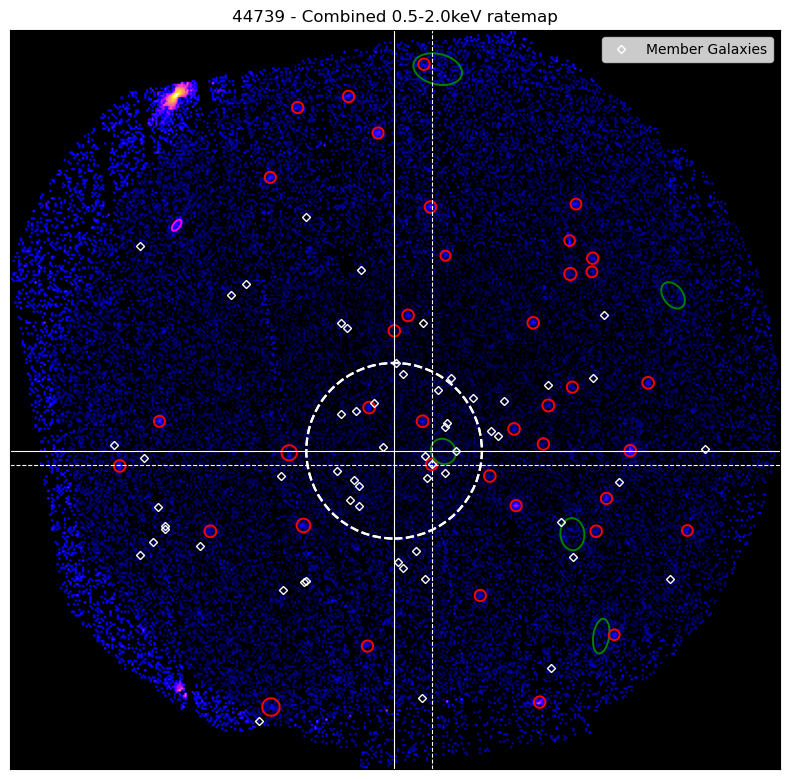




19670A


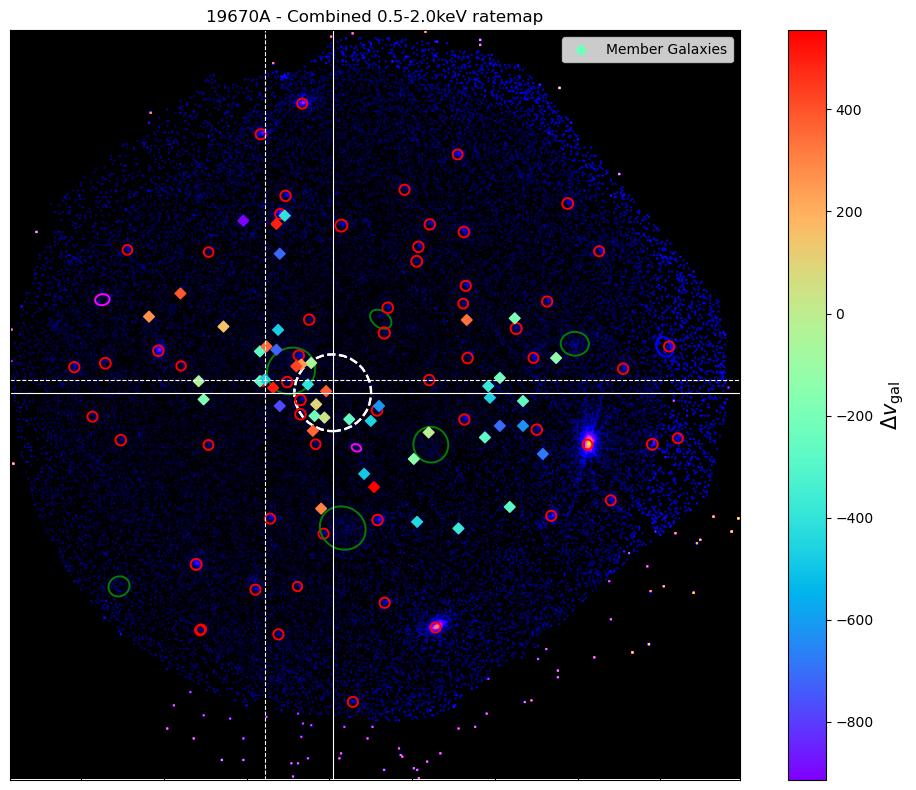

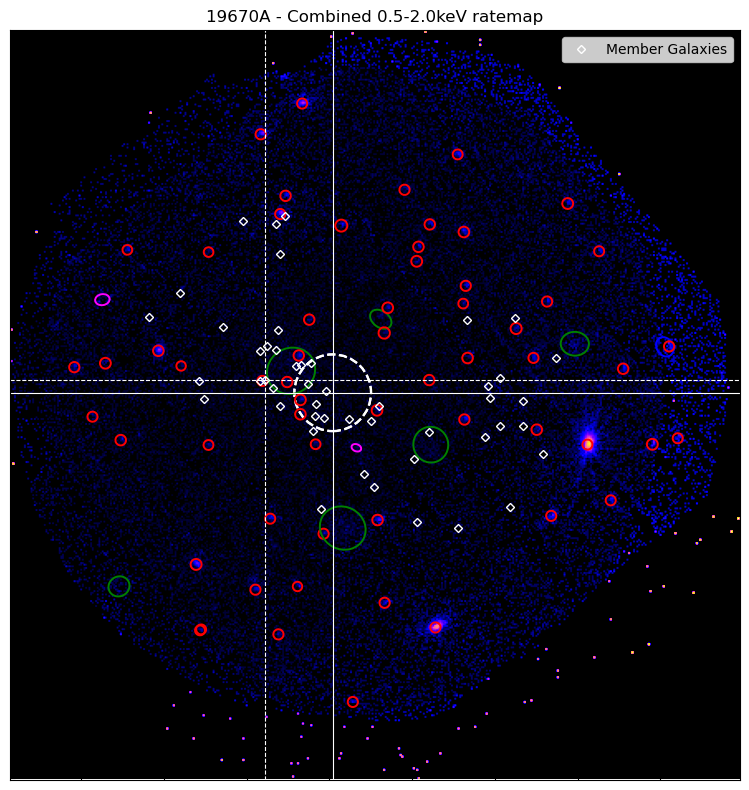




19670B


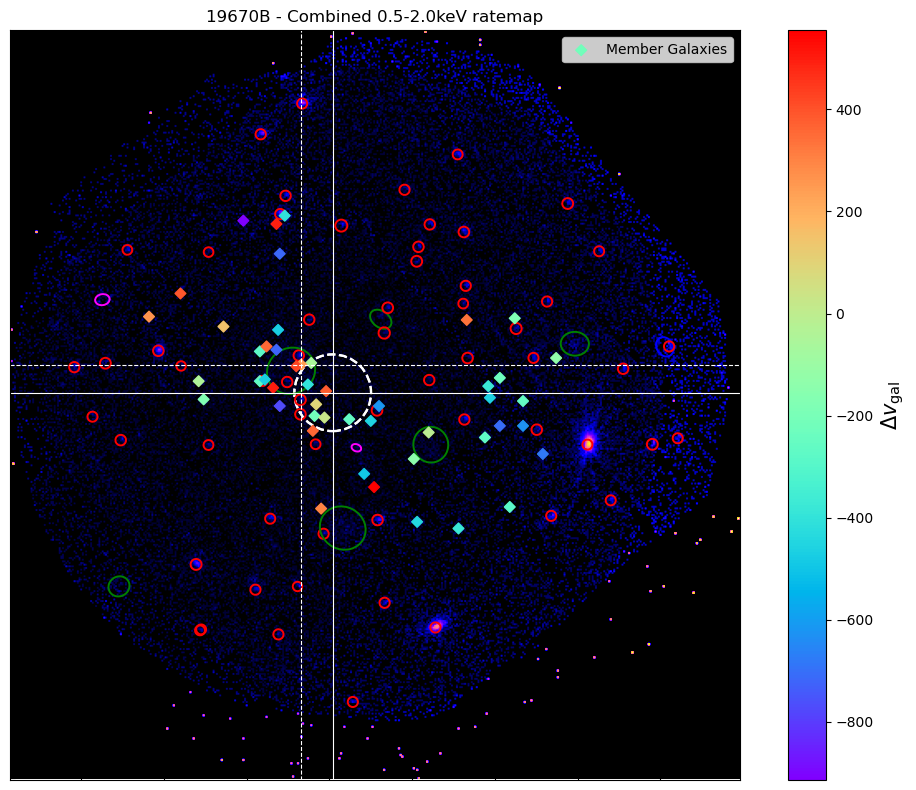

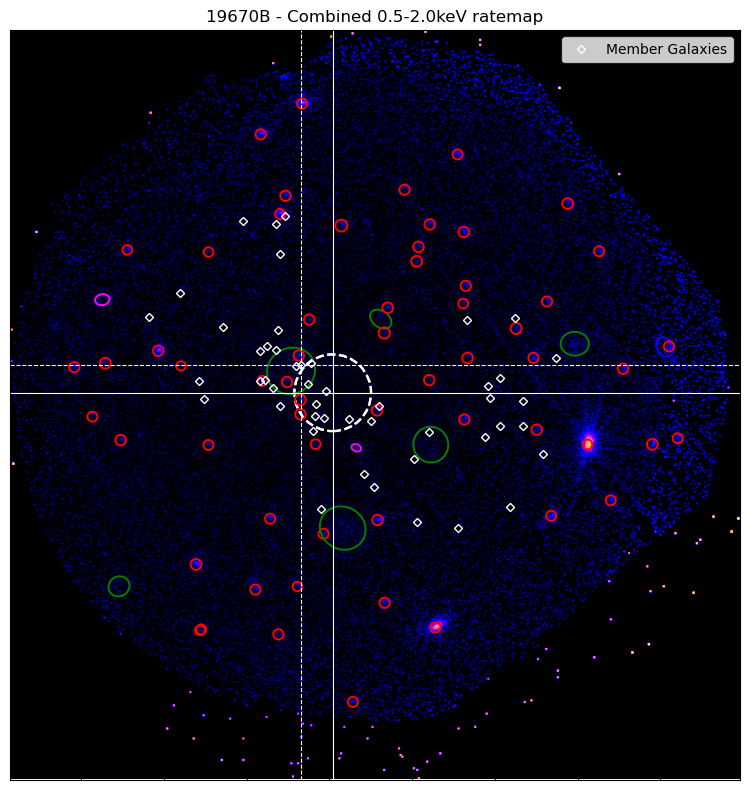




12833


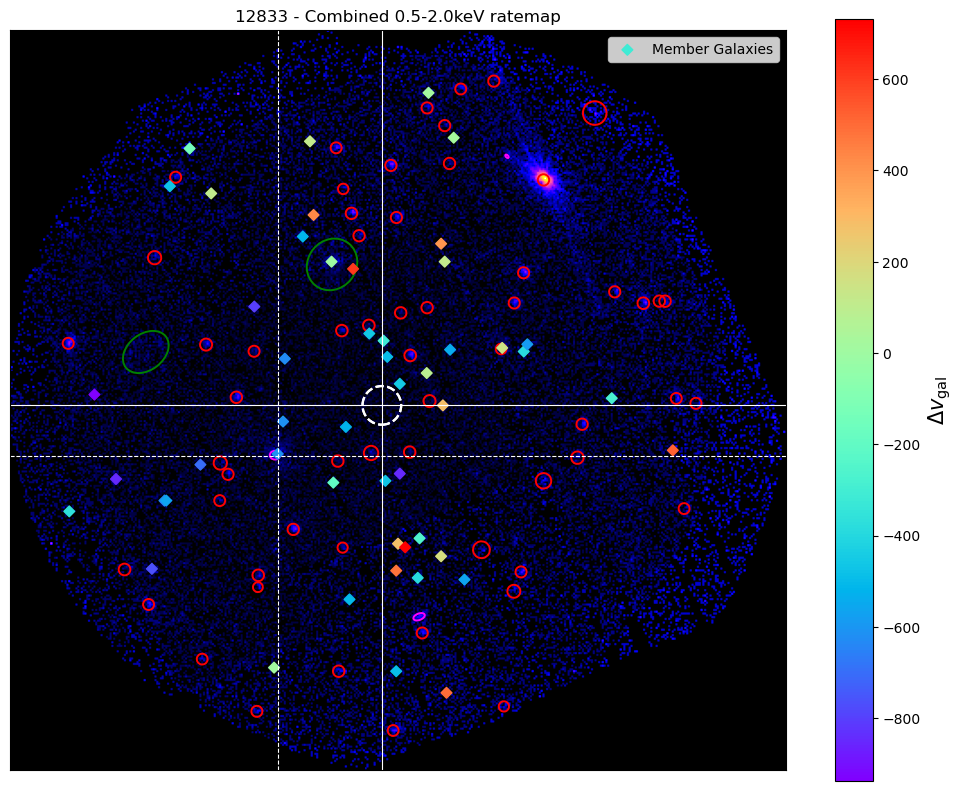

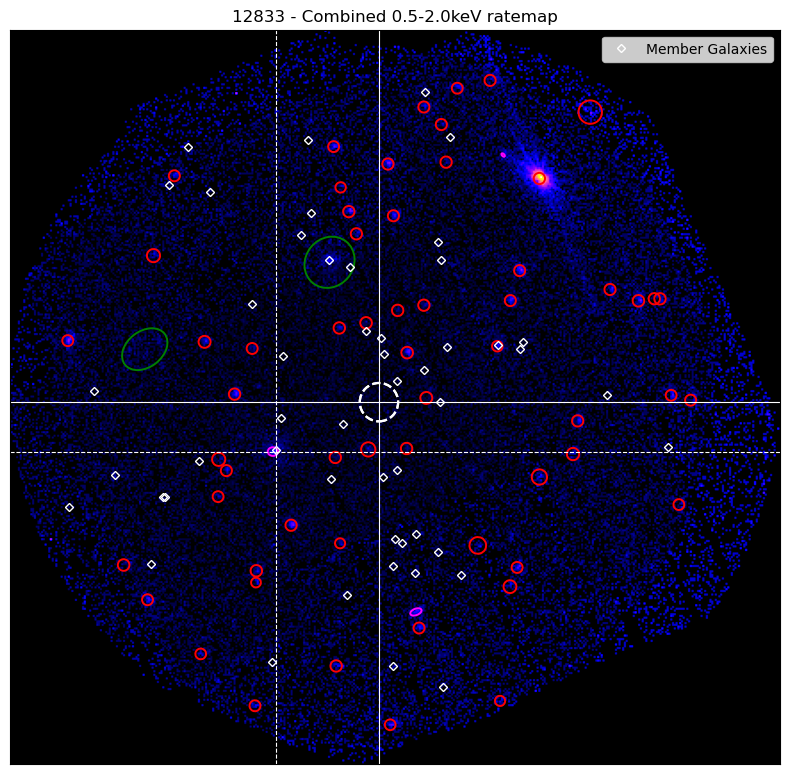




44858


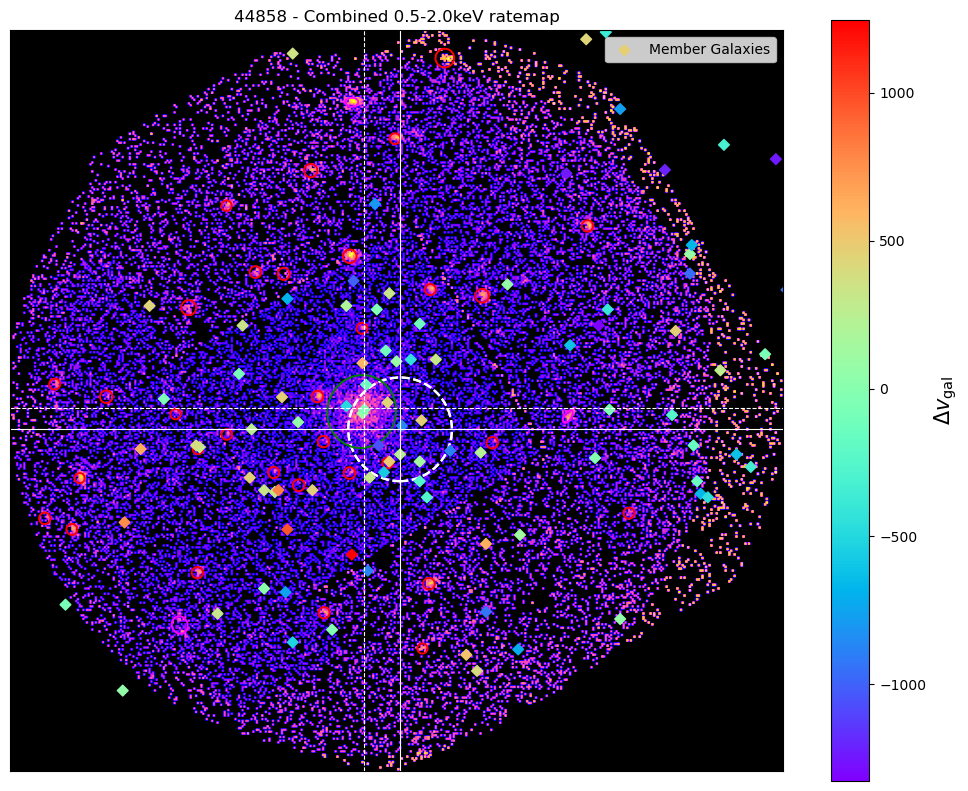

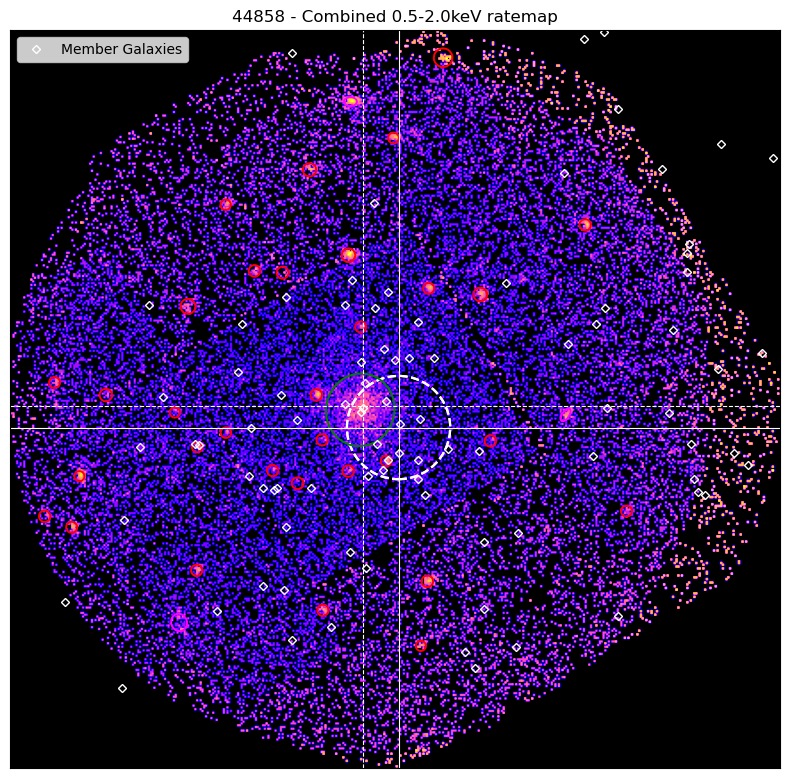




50433


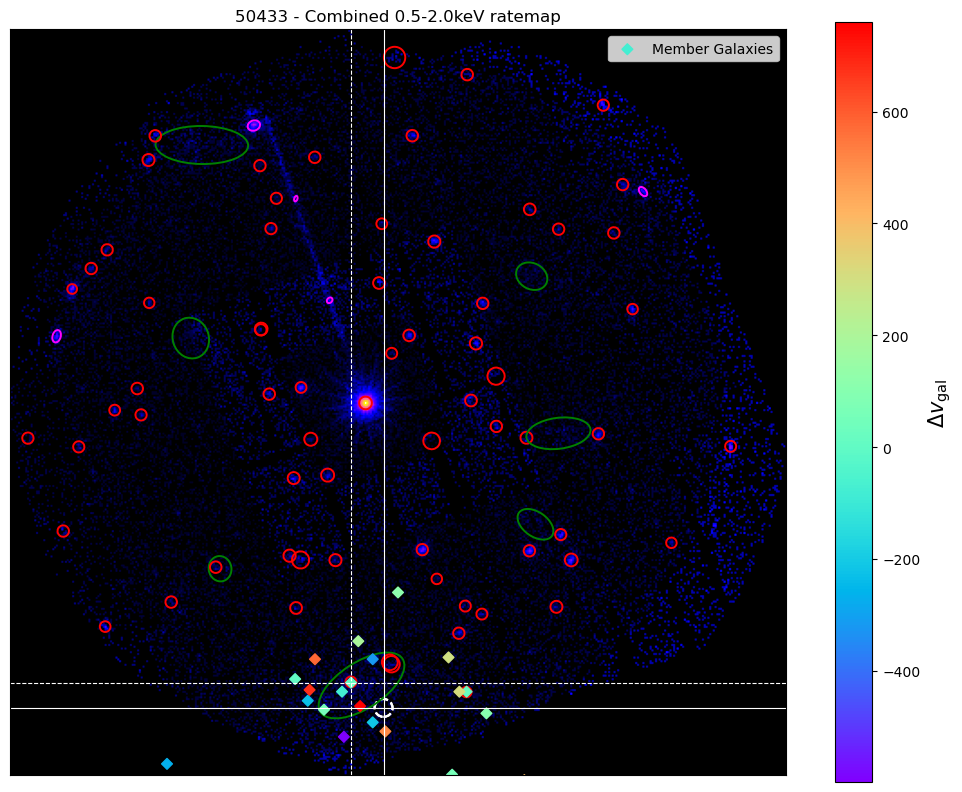

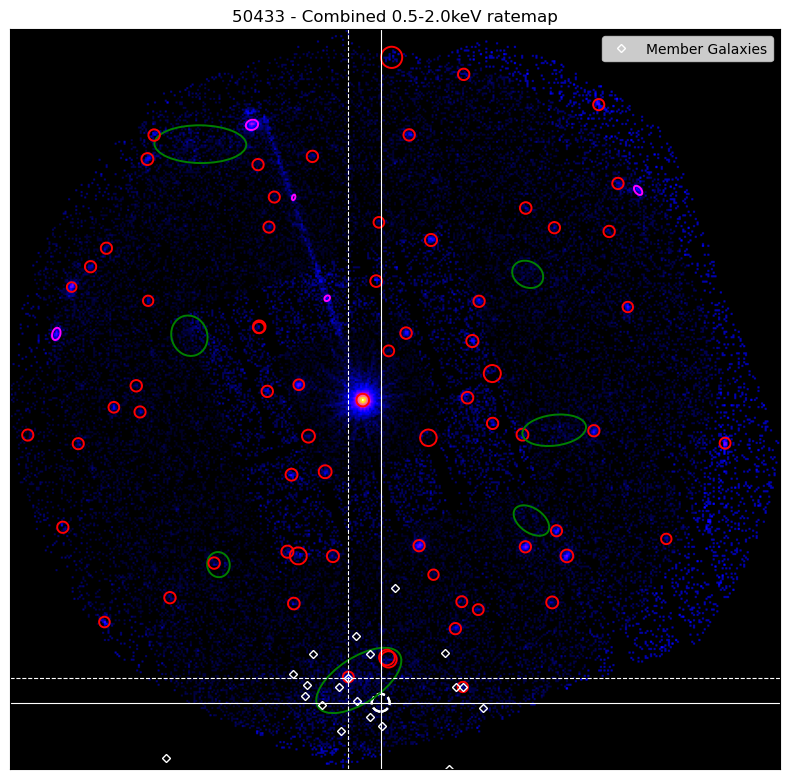

In [27]:
for src_ind, src in enumerate(srcs):
    rel_opt = opt_samp[opt_samp['name'] == src.name].iloc[0]
    
    if '19670' in src.name:
        grp_name = '19670'
    else:
        grp_name = src.name
    
    rel_mems = mem_gal_samp[mem_gal_samp['group_id'] == grp_name]

    opt_pos = Quantity(rel_opt[['opt_ra', 'opt_dec']], 'deg')
    pos_err = Quantity(rel_opt[['opt_ra_err', 'opt_dec_err']], 'deg').max()
    
    print(src.name)
    rt = src.get_combined_ratemaps()
    
    if any([len(r) != 1 for o, r in src._initial_regions.items()]):
        rt.regions = src._initial_regions
        
    pix_rad = (pos_err/pix_deg_scale(opt_pos, rt.radec_wcs)).value
    
    # Ideally I would just pass the whole chunk of RA-Dec coordinates in, but the way this method is
    #  designed at the moment it fails outright if there are <0 pixel coords - I'll add a way to make that
    #  more graceful at some point
#     mem_pix = rt.coord_conv(Quantity(rel_mems[['ra_gal', 'dec_gal']], 'deg'), 'pix').value
    mem_pix = []
    vels = []
    for row_ind, row in rel_mems.iterrows():
        try:
            mem_pix.append(rt.coord_conv(Quantity(row[['ra_gal', 'dec_gal']], 'deg'), 'pix').value)
            vels.append(row['delt_vel'])
        except ValueError:
            pass
    mem_pix = np.array(mem_pix)
    
    # First version with member galaxies - member galaxy markers are coloured by their delta-velocity
    #  from the group mean
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    ax = rt.get_view(ax, Quantity([opt_pos, src.ra_dec]), zoom_in=True, view_regions=True, 
                back_bin_pix=[pix_rad, pix_rad])
        
    sc = plt.scatter(mem_pix[:, 0], mem_pix[:, 1], marker='D', s=30, c=vels, cmap='rainbow', 
                     label='Member Galaxies')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(r'$\Delta v_{\rm{gal}}}$', fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # The member galaxies here are just all white
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax = rt.get_view(ax, Quantity([opt_pos, src.ra_dec]), zoom_in=True, view_regions=True, 
                back_bin_pix=[pix_rad, pix_rad])
        
    plt.plot(mem_pix[:, 0], mem_pix[:, 1], 'D', color='white', label='Member Galaxies', markersize=3.7, 
             markerfacecolor='None')
    plt.legend()
    plt.tight_layout()
    plt.savefig('../../outputs/figures/xray_ims/{n}_optxraypos_withmemgal_XMM52_FoV.png'.format(n=src.name))
    plt.show()
    
    # This is without member galaxies, and saved to disk
    rt.save_view('../../outputs/figures/xray_ims/{n}_optxraypos_XMM52_FoV.png'.format(n=src.name), 
                 Quantity([opt_pos, src.ra_dec]), zoom_in=True, view_regions=True, 
                 back_bin_pix=[pix_rad, pix_rad])

    
    print('\n\n')

## Difference between X-ray and optical centre

Here we create a figure to demonstrate the difference between the optical and X-ray defined centres for all of the groups on a single axis, simply subtracting the optical position from the X-ray and plotting the difference:

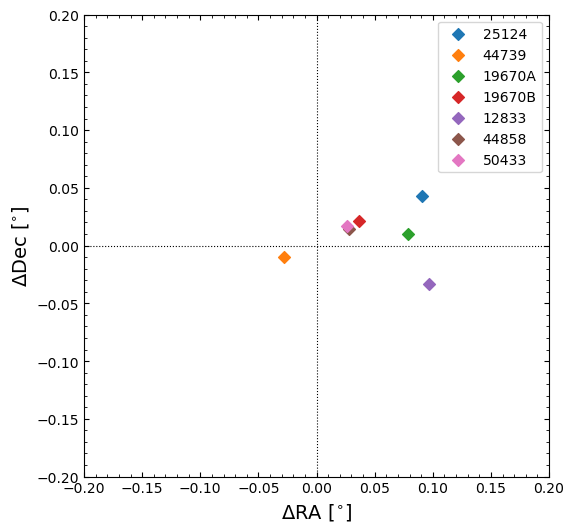

In [9]:
plt.figure(figsize=(6, 6))

# Set up the ticks on the x and y axes
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Adding a crosshair to emphasise the zero point
plt.axhline(0, linestyle='dotted', color='black', linewidth=0.8)
plt.axvline(0, linestyle='dotted', color='black', linewidth=0.8)

pnt_mark = ['x', 'D', '.', '+', '1', 'P', 'X']
for src_ind, src in enumerate(srcs):
    # Retrieving the relevant optical position information
    rel_opt = opt_samp[opt_samp['name'] == src.name].iloc[0]
    opt_pos = Quantity(rel_opt[['opt_ra', 'opt_dec']], 'deg')
    xray_pos = src.ra_dec
    
    # Calculating the difference between the X-ray and optical positions (the optical positions are 
    #  effectively) the zero point of this plot
    delt_ra = xray_pos[0]-opt_pos[0]
    delt_dec = xray_pos[1]-opt_pos[1]
    
#     plt.scatter(delt_ra, delt_dec, marker=pnt_mark[src_ind], label="{}".format(src.name))
    plt.scatter(delt_ra, delt_dec, marker='D', label="{}".format(src.name))

# Set sensible axis limits
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)

# Create labels
plt.xlabel(r'$\Delta$RA [$^{\circ}$]', fontsize=14)
plt.ylabel(r'$\Delta$Dec [$^{\circ}$]', fontsize=14)

# Add legend, plot, and save
plt.legend(loc='best')
plt.savefig('../../outputs/figures/opt_xray_pos_comp.pdf')
plt.show()

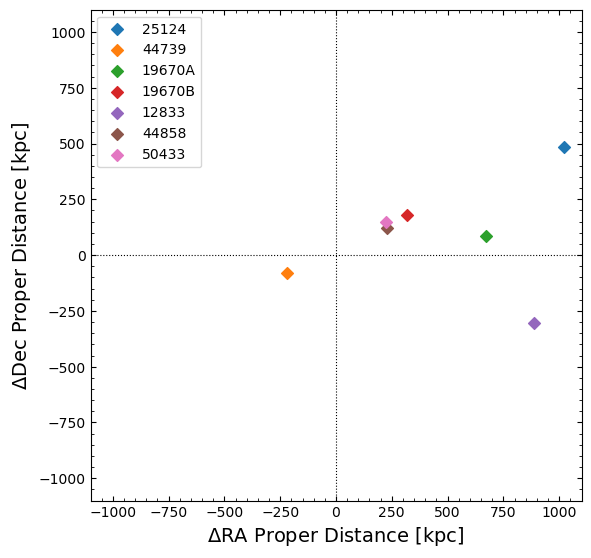

In [13]:
plt.figure(figsize=(6, 6))

# Set up the ticks on the x and y axes
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Adding a crosshair to emphasise the zero point
plt.axhline(0, linestyle='dotted', color='black', linewidth=0.8)
plt.axvline(0, linestyle='dotted', color='black', linewidth=0.8)

pnt_mark = ['x', 'D', '.', '+', '1', 'P', 'X']
for src_ind, src in enumerate(srcs):
    # Retrieving the relevant optical position information
    rel_opt = opt_samp[opt_samp['name'] == src.name].iloc[0]
    opt_pos = Quantity(rel_opt[['opt_ra', 'opt_dec']], 'deg')
    xray_pos = src.ra_dec
    
    # Calculating the difference between the X-ray and optical positions (the optical positions are 
    #  effectively) the zero point of this plot
    delt_x = ang_to_rad(xray_pos[0]-opt_pos[0], src.redshift, src.cosmo)
    delt_y = ang_to_rad(xray_pos[1]-opt_pos[1], src.redshift, src.cosmo)
    
#     plt.scatter(delt_ra, delt_dec, marker=pnt_mark[src_ind], label="{}".format(src.name))
    plt.scatter(delt_x, delt_y, marker='D', label="{}".format(src.name))

# Set sensible axis limits
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)

# Create labels
plt.xlabel(r'$\Delta$RA Proper Distance [kpc]', fontsize=14)
plt.ylabel(r'$\Delta$Dec Proper Distance [kpc]', fontsize=14)

# Add legend, plot, and save
plt.gca().set_aspect(1)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('../../outputs/figures/opt_xray_pos_kpc_comp.pdf')
plt.show()